In [1]:
root="/projects/ohlab/ruoyun/MECFS/train_model/MECFS"

In [2]:
import pandas as pd
import numpy as np
import glob

import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
from statannot import add_stat_annotation
import itertools

---

# import dataset here

In [3]:
kegg_table="kegg_gene_normalized_070120.txt"
metabolomics_table="Metabolon_raw_reads_count_2019_051520.csv"
abundance_table="metaphlan3_species_relative_abundance_062520.csv"
meta_table="MECFS_metadata_labels_062320.csv"

In [4]:
rela_abun = pd.read_csv("%s/data/metagenomics/%s" %(root, abundance_table), 
                   index_col=0)
rela_abun_decode = rela_abun.iloc[:,:14]
rela_abun_data = rela_abun.iloc[:,14:]
print(rela_abun_decode.shape)
print(rela_abun_data.shape)

kegg = pd.read_table("%s/data/metagenomics/%s" %(root, kegg_table), 
                     sep='\t', index_col=0)
kegg_decode = kegg.iloc[:,:1]
kegg_data = kegg.iloc[:,1:]
print(kegg_decode.shape)
print(kegg_data.shape)

bioc = pd.read_csv("%s/data/metabolomics/%s" %(root, metabolomics_table), 
                   index_col=0)
bioc_decode = bioc.iloc[:,:12]
bioc_data = bioc.iloc[:,12:]
print(bioc_decode.shape)
print(bioc_data.shape)

meta = pd.read_csv("%s/data/metadata/%s" %(root, meta_table), 
                   index_col=0)
meta_decode = meta.iloc[:, :4]
meta_data = meta.iloc[:, 4:]

print(meta_data.shape)

(384, 14)
(384, 224)
(9652, 1)
(9652, 224)
(1278, 12)
(1278, 184)
(6, 228)


# Omics matrix

In [5]:
feature_importance_table = "important_features.csv"

In [6]:
imp_table = pd.read_csv("%s/result/classification/%s" %(root, feature_importance_table), 
                   index_col=0)

In [7]:
omics_patient_data = pd.concat([
    bioc_data.loc[imp_table.loc[:,'patient_bioc_name'].ravel(), :],
    rela_abun_data.loc[imp_table.loc[:,'patient_abun_name'].ravel(), :],
    kegg_data.loc[imp_table.loc[:,'patient_kegg_name'].ravel(), :]], axis=0)

omics_onset_data = pd.concat([
    rela_abun_data.loc[imp_table.loc[:,'onset_abun_name'].ravel(), :],
    kegg_data.loc[imp_table.loc[:,'onset_kegg_name'].ravel(), :],
    bioc_data.loc[imp_table.loc[:,'onset_bioc_name'].ravel(), :]], axis=0)

In [8]:
omics_patient_importance = pd.read_csv("%s/result/classification/%s" %(root, "imp_features_patient_control.csv"), 
                                       index_col = 0)
omics_onset_importance = pd.concat([
    imp_table.loc[:,'onset_abun_importance'],
    imp_table.loc[:,'onset_kegg_importance'],
    imp_table.loc[:,'onset_bioc_importance']], axis=0)
omics_onset_importance.index = omics_onset_data.index

In [9]:
set(omics_patient_data.index).intersection(set(omics_onset_data.index))

{'1262824|Clostridium_sp_CAG_58',
 '1550024|Ruthenibacterium_lactatiformans',
 '292800|Flavonifractor_plautii',
 '33038|Ruminococcus_gnavus',
 '360807|Roseburia_inulinivorans',
 '418240|Blautia_wexlerae',
 'K00254',
 'K00567',
 'K21417',
 'K21576',
 'K21577',
 'X - 25172',
 'cholesterol'}

# prevalance

In [10]:
bioc_prev = pd.read_csv("%s/data/metabolomics/metabolomics_prevalance_061220.csv" %(root), index_col=0)
kegg_prev = pd.read_csv("%s/data/metagenomics/kegg_gene_prevalance_070220.csv" %(root), index_col=0)
abun_prev = pd.read_csv("%s/data/metagenomics/metaphlan3_specie_prevalance_071620.csv" %(root), index_col=0)

In [11]:
omics_patient_prev = pd.concat([
    bioc_prev.loc[imp_table.loc[:,'patient_bioc_name'].ravel(), ['control', 'MECFS']],
    abun_prev.loc[imp_table.loc[:,'patient_abun_name'].ravel(), ['control', 'MECFS']],
    kegg_prev.loc[imp_table.loc[:,'patient_kegg_name'].ravel(), ['control', 'MECFS']]], axis=0)

omics_onset_prev = pd.concat([
    abun_prev.loc[imp_table.loc[:,'onset_abun_name'].ravel(), ['control', '4_years', '10_years']],
    kegg_prev.loc[imp_table.loc[:,'onset_kegg_name'].ravel(), ['control', '4_years', '10_years']],
    bioc_prev.loc[imp_table.loc[:,'onset_bioc_name'].ravel(), ['control', '4_years', '10_years']]], axis=0)

# Plotting

In [12]:
raw_patient_data = pd.concat([
    bioc_data.loc[imp_table.loc[:,'patient_bioc_name'].ravel(), :],
    rela_abun_data.loc[imp_table.loc[:,'patient_abun_name'].ravel(), :],
    kegg_data.loc[imp_table.loc[:,'patient_kegg_name'].ravel(), :]], axis=0)

raw_onset_data = pd.concat([
    rela_abun_data.loc[imp_table.loc[:,'onset_abun_name'].ravel(), :],
    kegg_data.loc[imp_table.loc[:,'onset_kegg_name'].ravel(), :],
    bioc_data.loc[imp_table.loc[:,'onset_bioc_name'].ravel(), :]], axis=0)

In [13]:
table = raw_patient_data.copy()
table.loc['group', :] = meta_data.loc['study_ptorhc', :]
mean = table.transpose().groupby('group').mean().transpose()
std = table.transpose().groupby('group').std().transpose()
std = std / mean
mean.columns=['Control', 'MECFS']
std.columns=['Control', 'MECFS']

In [14]:
from scipy.stats import spearmanr as spearmanr
from importlib.machinery import SourceFileLoader
stat = SourceFileLoader("",  "/projects/ohlab/ruoyun/MECFS/train_model/MECFS/codes/stat_functions.py").load_module()

In [15]:
spearmanr(a = raw_patient_data.loc['K21578',:],
                      b = raw_patient_data.loc['33038|Ruminococcus_gnavus',:],
                      nan_policy = 'omit')

/projects/ohlab/ruoyun/data/database/conda/envs/py3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/projects/ohlab/ruoyun/data/database/conda/envs/py3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.4, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


SpearmanrResult(correlation=0.32402461830854484, pvalue=7.166151381791708e-07)

In [16]:
corr_table = stat.spearman_two_table(raw_patient_data.loc[['betaine', '292800|Flavonifractor_plautii', 
                                              '1262824|Clostridium_sp_CAG_58', '33038|Ruminococcus_gnavus'],:], 
                        raw_patient_data.loc[['K21576', 'K21577', 'K21578'],:])

In [17]:
corr_table

,K21576,K21577,K21578
betaine,-0.287464,-0.294612,-0.151823
292800|Flavonifractor_plautii,0.342144,0.390519,0.260909
1262824|Clostridium_sp_CAG_58,0.366890,0.393329,0.000000
33038|Ruminococcus_gnavus,0.389653,0.429321,0.324025


In [18]:
corr_table.index = ['bataine in plasma'] + list(omics_patient_importance.loc[corr_table.index, 'name'][1:])
corr_table.columns = [i.split("|")[1] for i in omics_patient_importance.loc[corr_table.columns, 'name']]

Text(0.5, 7.0, '')

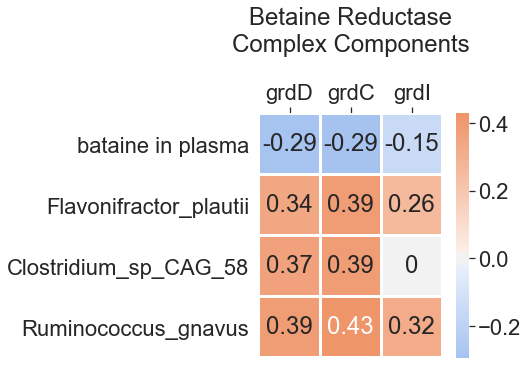

In [19]:
sns.set(style='white', font_scale=2, font = 'Arial')
fig = plt.figure(figsize=(5,4.5))
ax = sns.heatmap(corr_table,
            cmap=sns.diverging_palette(250, 30, l=70, as_cmap=True),
           center = 0,
           annot=True,
           linewidths=2,
           square=True)
ax.xaxis.set_ticks_position('top')
plt.title("Betaine Reductase\nComplex Components\n ")
plt.ylabel("")
plt.xlabel("")
#plt.savefig("%s/result/figures/%s" %(root, "Betaine_corr.pdf"), dpi=1000, bbox_inches='tight')

In [20]:
#index = omics_patient_importance.iloc[:10].index
#gene_name = [i.split(';')[0] for i in kegg_decode.loc[index, 'definition']]
#new_name = []
#for i in range(10):
#    new_name.append(index[i] + '|' + gene_name[i])
#new_name[3] = "K09740"
#omics_patient_importance.loc[index,'name'] = new_name

In [21]:
#index = omics_patient_importance.iloc[20:].index
#new_name = []
#for i in index:
#    new_name.append(i.split('|')[1])
#omics_patient_importance.loc[index,'name'] = new_name

In [22]:
def color_decode_func(annotation_table, palette_name):
    keys = set(annotation_table.values.ravel())
    colors = sns.color_palette(palette_name, len(keys))
    color_dict = dict(zip(keys, colors))
    color_dict['0'] = "white"
    return color_dict

In [23]:
from matplotlib.lines import Line2D
def build_legend(data):
    legend_elements = []
    for key in data:
        legend_elements.append(Line2D([0], [0], marker='s', color='w', label=key,
                                        markerfacecolor=data[key], markersize=10))
    return legend_elements

In [30]:
mean.columns = ['control', 'patient']

In [32]:
std.columns = ['control', 'patient']

/projects/ohlab/ruoyun/data/database/conda/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/projects/ohlab/ruoyun/data/database/conda/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:89: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/projects/ohlab/ruoyun/data/database/conda/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:93: MatplotlibDeprecationWarni

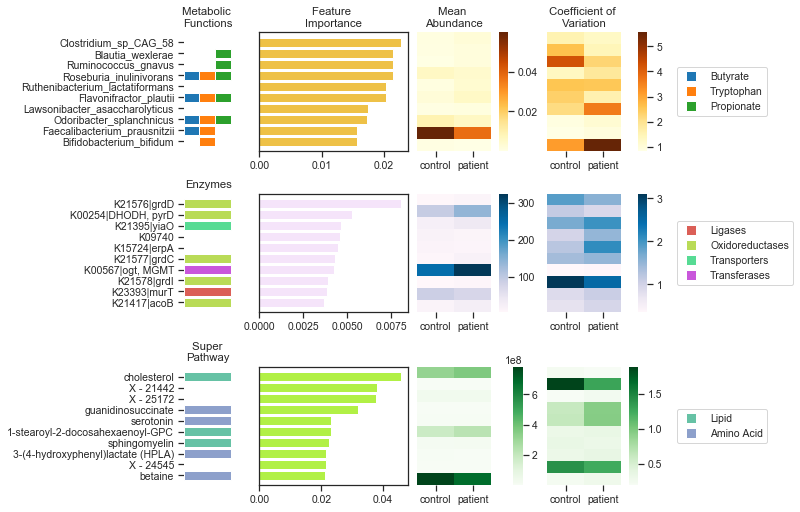

In [34]:
kegg_index = omics_patient_importance.iloc[:10].index[::-1]
kegg_annot = 'Enzymes'
kegg_table = omics_patient_importance.loc[kegg_index,['Importance', 'name'] + [kegg_annot]]
kegg_color = color_decode_func(kegg_table.loc[:,kegg_annot], "hls")

bioc_index = omics_patient_importance.iloc[10:20].index[::-1]
bioc_annot = 'Super Pathway'
bioc_table = omics_patient_importance.loc[bioc_index, ['Importance', 'name'] + [bioc_annot]]
bioc_color = color_decode_func(bioc_table.loc[:,bioc_annot], "Set2")

abun_index = omics_patient_importance.iloc[20:].index[::-1]
abun_annot = ['Butyrate', 'Tryptophan', 'Propionate']
abun_table = omics_patient_importance.loc[abun_index, ['Importance', 'name'] + abun_annot]
abun_color = dict(zip(abun_annot, sns.color_palette("tab10", 3)))

sns.set(style='ticks', font_scale=0.95, font='Arial', rc={"lines.linewidth": 0.5})
fig = plt.figure(figsize=(11,7), constrained_layout=True)

widths = [2, 6, 3, 3, 4] 
heights = [6, 6, 6]
spec = fig.add_gridspec(ncols=5, nrows=3, width_ratios=widths,
                          height_ratios=heights)

ax = fig.add_subplot(spec[0, 0])
ax.barh(abun_table.loc[:,'name'], [1] * 10, 
         color=[abun_color[abun_annot[0]] if i == 'Y' else 'white' for i in abun_table.loc[:,abun_annot[0]]])
ax.barh(abun_table.loc[:,'name'], [1] * 10, left = [1] * 10,
         color=[abun_color[abun_annot[1]] if i == 'Y' else 'white' for i in abun_table.loc[:,abun_annot[1]]])
ax.barh(abun_table.loc[:,'name'], [1] * 10, left = [2] * 10,
         color=[abun_color[abun_annot[2]] if i == 'Y' else 'white' for i in abun_table.loc[:,abun_annot[2]]])
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title("Metabolic \nFunctions")

ax = fig.add_subplot(spec[1, 0])
ax.barh(kegg_table.loc[:,'name'], 
        [1] * 10, 
        color=[kegg_color[i] for i in list(kegg_table.loc[:, kegg_annot])])
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title(kegg_annot)

ax = fig.add_subplot(spec[2, 0])
ax.barh(bioc_table.loc[:,'name'], 
        [1] * 10, 
        color=[bioc_color[i] for i in list(bioc_table.loc[:, bioc_annot])])
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title("Super \nPathway")

ax = fig.add_subplot(spec[0, 1])
ax.barh(abun_table.loc[:,'name'], 
        abun_table.loc[:,'Importance'], 
        color="#EEC147")
ax.set_yticks([])
ax.set_title("Feature \nImportance")

ax = fig.add_subplot(spec[1, 1])
ax.barh(kegg_table.loc[:,'name'], 
        kegg_table.loc[:,'Importance'], 
        color="#F5E4FA")
ax.set_yticks([])

ax = fig.add_subplot(spec[2, 1])
ax.barh(bioc_table.loc[:,'name'], 
        bioc_table.loc[:,'Importance'], 
        color="#B1F045")
ax.set_yticks([])

ax = fig.add_subplot(spec[0, 2])
sns.heatmap(mean.loc[abun_index[::-1],:], cmap="YlOrBr", ax = ax)
ax.set_yticks([])
ax.set_title("Mean \nAbundance")

ax = fig.add_subplot(spec[0, 3])
sns.heatmap(std.loc[abun_index[::-1],:], cmap="YlOrBr", ax = ax)
ax.set_yticks([])
ax.set_title("Coefficient of \nVariation")

ax = fig.add_subplot(spec[1, 2])
sns.heatmap(mean.loc[kegg_index[::-1],:], cmap="PuBu", ax = ax)
ax.set_yticks([])

ax = fig.add_subplot(spec[1, 3])
sns.heatmap(std.loc[kegg_index[::-1],:], cmap="PuBu", ax = ax)
ax.set_yticks([])

ax = fig.add_subplot(spec[2, 2])
sns.heatmap(mean.loc[bioc_index[::-1],:], cmap="Greens", ax = ax)
ax.set_yticks([])

ax = fig.add_subplot(spec[2, 3])
sns.heatmap(std.loc[bioc_index[::-1],:], cmap="Greens", ax = ax)
ax.set_yticks([])

ax = fig.add_subplot(spec[0, 4])
legend_elements = build_legend(abun_color)
ax.legend(handles=legend_elements, loc='center left')

ax = fig.add_subplot(spec[1, 4])
kegg_color.pop('0')
legend_elements = build_legend(kegg_color)
ax.legend(handles=legend_elements, loc='center left')

ax = fig.add_subplot(spec[2, 4])
bioc_color.pop('0')
legend_elements = build_legend(bioc_color)
ax.legend(handles=legend_elements, loc='center left')

#plt.savefig("%s/result/figures/%s" %(root, "omics_imp_30_patient_control.png"), dpi=1000, bbox_inches='tight')

In [25]:
color_dict = {1.0: '#5F74A8', 2.0: '#DC4C68'}

def Box_plot(data_mat, stat_type, color_dict, fig):
    '''This version filtered out the outlier : Q1-1.5IQR and Q3+1.5IQR
    input dataframe: features in row, sample in column, group information named group in row,
    stat_type yield to the stat type in add_stat_annotation function,
    color_dict share the same catagories as group row,
    fig is matlibplot object,
    output_table: rank p value and the mean for each group, fold change included for group 2'''
    group_vector = data_mat.loc['group',:]
    data_mat = data_mat.drop('group', axis=0)
    n = len(data_mat.index)
    for i in range(n):
        ## set subgroup axis
        m = int(np.sqrt(n))
        if m ** 2 < n:
            m += 1
        ax = fig.add_subplot(m + 1, m + 1, i+1)

        ## Remove na
        data_i = pd.concat([group_vector, data_mat.iloc[i, :]],axis=1).dropna(axis=0)

        ## filtering Values between Q1-1.5IQR and Q3+1.5IQR
        q1 = data_i.iloc[:,1].quantile(0.25)
        q3 = data_i.iloc[:,1].quantile(0.75)
        iqr = q3 - q1
        if iqr != 0:
            data_i = data_i.loc[(data_i.iloc[:,1] < q3 + 1.5 * iqr) &
                               (data_i.iloc[:,1] > q1 - 1.5 * iqr), :]

        x = data_i.columns[0]
        y = data_i.columns[1]
        sns.boxplot(x=x, y=y,
                data=data_i,
                palette=color_dict,
                ax=ax, linewidth = 2)
        #ax.ticklabel_format(style = 'sci', axis = 'y', scilimits=(-2,-2))
        sns.swarmplot(x=x, y=y,
                      data=data_i,
                      color='.2',
                      ax=ax, s = 3)
        add_stat_annotation(ax, data=data_i,
                            x=x, y=y,
                            box_pairs=list(itertools.combinations(data_i.loc[:,x].value_counts().index, 2)),
                            test=stat_type,
                            text_format='star',
                            loc='inside',
                            verbose=2)
        ax.set_xticks([])
        ax.set_xlabel('')
        ax.set_ylabel(y, fontsize=9)
    
    plt.tight_layout()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1.0 v.s. 2.0: Welch's t-test independent samples with Bonferroni correction, P_val=5.893e-06 stat=-4.649e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1.0 v.s. 2.0: Welch's t-test independent samples with Bonferroni correction, P_val=3.827e-04 stat=-3.612e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1.0 v.s. 2.0: Welch's t-test independent samples with Bonferroni correction, P_val=3.647e-04 stat=-3.631e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1.0 v.s. 2.0: Wel

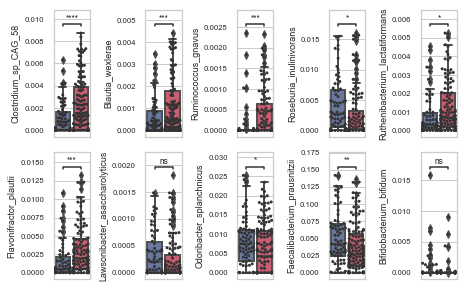

In [26]:
table = raw_patient_data.loc[omics_patient_importance.index, :]
table.index = omics_patient_importance.loc[:,'name']
table = table.iloc[20:,:]
table.loc['group',:] = meta_data.loc['study_ptorhc',:]

sns.set(style='whitegrid', font_scale=0.7, font='Arial')
fig = plt.figure(figsize=(6.5,10), tight_layout = True)

Box_plot(table, stat_type='t-test_welch', color_dict=color_dict, fig = fig)
#plt.savefig("%s/result/figures/%s" %(root, "stat_imp_10_abun_patient_control.png"), dpi=1000, bbox_inches='tight')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1.0 v.s. 2.0: Welch's t-test independent samples with Bonferroni correction, P_val=1.489e-06 stat=-4.985e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1.0 v.s. 2.0: Welch's t-test independent samples with Bonferroni correction, P_val=2.627e-04 stat=-3.719e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1.0 v.s. 2.0: Welch's t-test independent samples with Bonferroni correction, P_val=5.031e-06 stat=-4.695e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1.0 v.s. 2.0: Wel

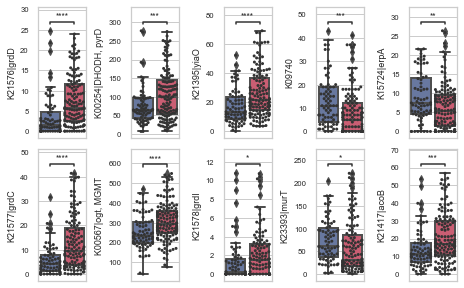

In [27]:
table = raw_patient_data.loc[omics_patient_importance.index, :]
table.index = omics_patient_importance.loc[:,'name']
table = table.iloc[:10,:]
table.loc['group',:] = meta_data.loc['study_ptorhc',:]

sns.set(style='whitegrid', font_scale=0.7, font='Arial')
fig = plt.figure(figsize=(6.5,10), tight_layout = True)

Box_plot(table, stat_type='t-test_welch', color_dict=color_dict, fig = fig)
#plt.savefig("%s/result/figures/%s" %(root, "stat_imp_10_kegg_patient_control.png"), dpi=1000, bbox_inches='tight')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1.0 v.s. 2.0: Welch's t-test independent samples with Bonferroni correction, P_val=2.083e-04 stat=-3.844e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1.0 v.s. 2.0: Welch's t-test independent samples with Bonferroni correction, P_val=3.377e-01 stat=9.669e-01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1.0 v.s. 2.0: Welch's t-test independent samples with Bonferroni correction, P_val=2.501e-02 stat=2.264e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1.0 v.s. 2.0: Welch

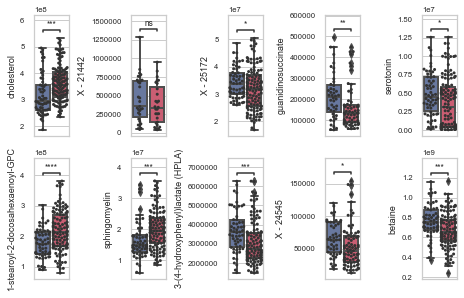

In [28]:
table = raw_patient_data.loc[omics_patient_importance.index, :]
table.index = omics_patient_importance.loc[:,'name']
table = table.iloc[10:20,:]
table.loc['group',:] = meta_data.loc['study_ptorhc',:]

sns.set(style='whitegrid', font_scale=0.7, font='Arial')
fig = plt.figure(figsize=(6.5,10), tight_layout = True)

Box_plot(table, stat_type='t-test_welch', color_dict=color_dict, fig = fig)
#plt.savefig("%s/result/figures/%s" %(root, "stat_imp_10_bioc_patient_control.png"), dpi=1000, bbox_inches='tight')

# Onset

In [196]:
table = omics_onset_data.copy()
table.loc['group', :] = meta_data.loc['illness_duration', :]
mean = table.transpose().groupby('group').mean().transpose()
std = table.transpose().groupby('group').std().transpose()
mean.columns=['control', 'early', 'late']
std.columns=['control', 'early', 'early']

In [197]:
index = omics_onset_importance.iloc[10:20].index
gene_name = [i.split(';')[0] for i in kegg_decode.loc[index, 'definition']]
new_name = []
for i in range(10):
    new_name.append(index[i] + '|' + gene_name[i])
    
onset_index = omics_onset_importance.index.ravel()
new_name[8] = 'K16907'
onset_index[10:20] = new_name
new_name = [i.split('|')[1] for i in omics_onset_importance.iloc[:10].index]
onset_index[:10] = new_name
omics_onset_importance.index = onset_index
mean.index = onset_index

/projects/ohlab/ruoyun/data/database/conda/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/projects/ohlab/ruoyun/data/database/conda/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


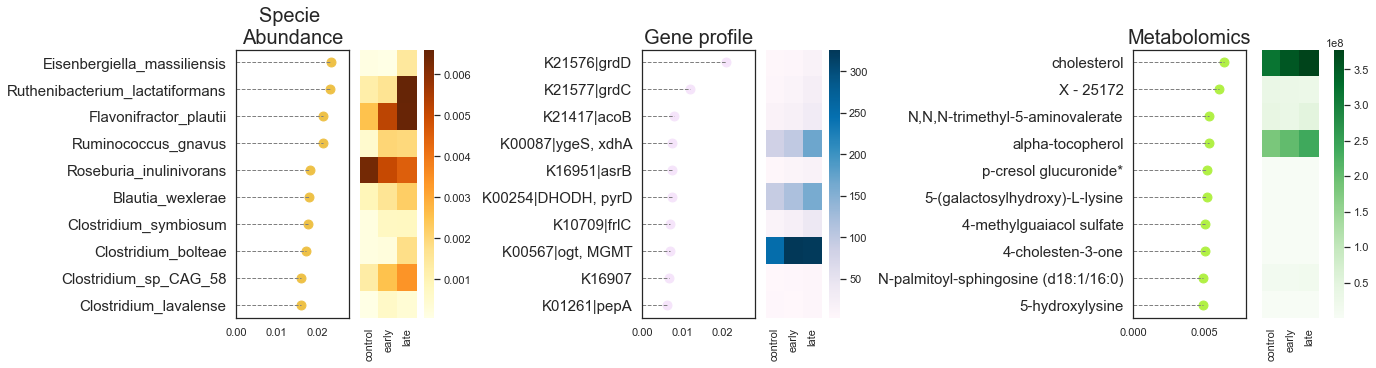

In [199]:
kegg_index = omics_onset_importance.iloc[10:20].index[::-1]
kegg_imp = omics_onset_importance.loc[kegg_index, ]
kegg_mean = mean.loc[kegg_index, ]

bioc_index = omics_onset_importance.iloc[20:].index[::-1]
bioc_imp = omics_onset_importance.loc[bioc_index, ]
bioc_mean = mean.loc[bioc_index, ]

abun_index = omics_onset_importance.iloc[:10].index[::-1]
abun_imp = omics_onset_importance.loc[abun_index, ]
abun_mean = mean.loc[abun_index, ]

sns.set(style='white', font_scale=1, font='Arial')
fig = plt.figure(figsize=(19,5), constrained_layout=True)

widths = [2, 1, 2, 1, 2, 1] 
spec = fig.add_gridspec(ncols=6, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0, 0])
ax.scatter(y = abun_index, 
        x = abun_imp, 
        color="#EEC147", s = 80)
ax.set_xlim(0, 0.028)
for i in abun_index:
    ax.hlines(i, 0, abun_imp[i], linestyles = 'dashed', lw = 1, colors = 'grey')
#ax.plot([0,len(xs)],[40,40],'r--',lw=2)
#plt.hlines(omics_onset_importance.index[::-1][0], 0, 1)
ax.set_title("Specie \nAbundance", fontsize = 20)
ax.tick_params(axis='y', labelsize=15)

ax = fig.add_subplot(spec[0, 2])
ax.scatter(y = kegg_index, 
        x = kegg_imp, 
        color="#F5E4FA", s = 80)
ax.set_xlim(0, 0.028)
for i in kegg_index:
    ax.hlines(i, 0, kegg_imp[i], linestyles = 'dashed', lw = 1, colors = 'grey')
#ax.plot([0,len(xs)],[40,40],'r--',lw=2)
#plt.hlines(omics_onset_importance.index[::-1][0], 0, 1)
ax.set_title("Gene profile", fontsize = 20)
ax.tick_params(axis='y', labelsize=15)

ax = fig.add_subplot(spec[0, 4])
ax.scatter(y = bioc_index, 
        x = bioc_imp, 
        color="#B1F045", s = 80)
ax.set_xlim(0, 0.008)
for i in bioc_index:
    ax.hlines(i, 0, bioc_imp[i], linestyles = 'dashed', lw = 1, colors = 'grey')
#ax.plot([0,len(xs)],[40,40],'r--',lw=2)
#plt.hlines(omics_onset_importance.index[::-1][0], 0, 1)
ax.set_title("Metabolomics", fontsize = 20)
ax.tick_params(axis='y', labelsize=15)

ax = fig.add_subplot(spec[0, 1])
sns.heatmap(abun_mean[::-1], cmap="YlOrBr", ax = ax, 
            cbar_kws={"aspect": 100})
ax.set_yticks([])

ax = fig.add_subplot(spec[0, 3])
sns.heatmap(kegg_mean[::-1], cmap="PuBu", ax = ax, cbar_kws={"aspect": 100})
ax.set_yticks([])

ax = fig.add_subplot(spec[0, 5])
sns.heatmap(bioc_mean[::-1], cmap="Greens", ax = ax, cbar_kws={"aspect": 100})
ax.set_yticks([])

#plt.savefig("%s/result/figures/%s" %(root, "omics_imp_30_onset.png"), dpi=1000, bbox_inches='tight')